###Pair Bonafide Dataset with Different Angle

In [1]:
import os
import itertools

# ------------------------
# Folder and output paths
# ------------------------
bonafide_dir = "/kaggle/input/face-morph-dsp/FRLL_preprocessed/FRLL_preprocessed/bonafide"
output_file  = "/kaggle/working/FRLL_bonafide.txt"


# Only include selected codes (you can adjust if needed)
valid_codes = {"02","03","04","07","09", "08"}

# ------------------------
# List all JPG files
# ------------------------
bonafide_files = sorted([f for f in os.listdir(bonafide_dir) if f.lower().endswith(".jpg")])

print("Total bonafide images:", len(bonafide_files))
print("Sample files:", bonafide_files[:6])

# ------------------------
# Group by person (before '_') and filter by code (after '_')
# ------------------------
grouped = {}
for f in bonafide_files:
    if "_" in f:
        person_id, code = f.split("_")
        code = code.split(".")[0]  # remove .jpg
        if code in valid_codes:
            grouped.setdefault(person_id, []).append(f)

# ------------------------
# Generate all combinations within same person
# ------------------------
pairs = []
for person, files in grouped.items():
    if len(files) >= 2:
        for a, b in itertools.combinations(files, 2):
            pairs.append(f"{a} {b}")

# ------------------------
# Save pairs to file
# ------------------------
with open(output_file, "w") as f:
    f.write("\n".join(pairs))

print(f"✅ Done! Created bonafide_pairs.txt with {len(pairs)} pairs.")
print(f"📄 Saved to: {output_file}")


Total bonafide images: 612
Sample files: ['001_02.jpg', '001_03.jpg', '001_04.jpg', '001_07.jpg', '001_08.jpg', '001_09.jpg']
✅ Done! Created bonafide_pairs.txt with 1530 pairs.
📄 Saved to: /kaggle/working/FRLL_bonafide.txt


In [2]:
import os
import itertools

# Folder containing all images like 1-01.jpg, 1-02.jpg, etc.
bonafide_dir = "/kaggle/input/face-morph-dsp/FEI_preprocessed/FEI_preprocessed/bonafide"

# Output file
bonafide_pairs_file = "/kaggle/working/FEI_bonafide.txt"

# Only use these emotion/angle codes
valid_codes = {"04", "05", "06", "07", "11", "12", "13"}

# List only JPG files
bonafide_files = sorted([f for f in os.listdir(bonafide_dir) if f.lower().endswith(".jpg")])

# Group images by person number (before the "-")
grouped = {}
for f in bonafide_files:
    if "-" in f:
        person_id, code = f.split("-")
        code = code.split(".")[0]  # remove .jpg
        if code in valid_codes:
            grouped.setdefault(person_id, []).append(f)

# Create bonafide-bonafide pairs (within same person)
bonafide_pairs = []
for person, files in grouped.items():
    if len(files) >= 2:
        # make all unique pairs (e.g., 03-04, 03-05, etc.)
        for a, b in itertools.combinations(files, 2):
            bonafide_pairs.append(f"{a} {b}")

# Save to file
with open(bonafide_pairs_file, "w") as f:
    f.write("\n".join(bonafide_pairs))

print(f"✅ Done! Created bonafide_pairs.txt with {len(bonafide_pairs)} pairs.")
print(f"📄 Saved to: {bonafide_pairs_file}")


✅ Done! Created bonafide_pairs.txt with 4200 pairs.
📄 Saved to: /kaggle/working/FEI_bonafide.txt


#Label Bonafide and Morph Pair in csv file

In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

In [4]:

# ==================================================
# 1. LOAD BONAFIDE PAIRS FROM TXT FILE
# ==================================================
def load_bonafide_pairs(txt_path):
    pairs = []
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            a, b = parts
            pairs.append((a, b, 0))  # label = 0
    return pairs


In [5]:

# ==================================================
# 2. FEI: BONAFIDE FROM TXT + ORIGINAL WORKING MORPH CODE
# ==================================================
def create_dmad_labels_fei(base_dir, txt_path):
    bona_dir  = os.path.join(base_dir, "bonafide")
    morph_dir = os.path.join(base_dir, "morphed")
    out_csv   = "/kaggle/working/FEI_dmad_labels.csv"

    records = []

    # ------------------ BONAFIDE FROM TEXT FILE ------------------
    bonafide_pairs = load_bonafide_pairs(txt_path)

    for a, b, lbl in bonafide_pairs:
        img1 = os.path.join(bona_dir, a)
        img2 = os.path.join(bona_dir, b)
        records.append([img1.replace("\\","/"),
                        img2.replace("\\","/"),
                        0])

    # ------------------ MORPH (ORIGINAL SUCCESSFUL CODE) ------------------
    morph_files = sorted(os.listdir(morph_dir))

    for f in morph_files:
        if not f.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        base = os.path.splitext(f)[0]     # e.g. 43-11_99-11_1
        id1  = base.split("_")[0]         # → 43-11

        bona_path = os.path.join(bona_dir, f"{id1}.jpg")
        morph_path = os.path.join(morph_dir, f)

        if os.path.exists(bona_path):  # ✔ ORIGINAL CHECK
            records.append([
                bona_path.replace("\\","/"),
                morph_path.replace("\\","/"),
                1
            ])

    df = pd.DataFrame(records, columns=["image1","image2","label"])
    df.to_csv(out_csv, index=False)

    print("\n🔥 FEI labeling complete →", out_csv)
    print("Bonafide:", (df.label==0).sum())
    print("Morph:", (df.label==1).sum())
    return df


In [6]:

# ==================================================
# 3. FRLL: BONAFIDE FROM TXT + ORIGINAL WORKING MORPH CODE
# ==================================================
def create_dmad_labels_frll(base_dir, txt_path):
    bona_dir  = os.path.join(base_dir, "bonafide")
    bona_dir2  = os.path.join(base_dir, "FRLL_bonafide")
    morph_dir = os.path.join(base_dir, "morphed")
    out_csv   = "/kaggle/working/FRLL_dmad_labels.csv"

    records = []

    # ------------------ BONAFIDE FROM TEXT FILE ------------------
    bonafide_pairs = load_bonafide_pairs(txt_path)

    for a, b, lbl in bonafide_pairs:
        img1 = os.path.join(bona_dir, a)
        img2 = os.path.join(bona_dir, b)
        records.append([img1.replace("\\","/"),
                        img2.replace("\\","/"),
                        0])

    # ------------------ MORPH (ORIGINAL SUCCESSFUL CODE) ------------------
    morph_files = sorted(os.listdir(morph_dir))

    for f in morph_files:
        if not f.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        base = os.path.splitext(f)[0]    # e.g. 173_03-142_03_1
        id1  = base.split("-")[0]        # → 173_03

        bona_path = os.path.join(bona_dir2, f"{id1}.jpg")
        morph_path = os.path.join(morph_dir, f)

        if os.path.exists(bona_path):  # ✔ ORIGINAL CHECK
            records.append([
                bona_path.replace("\\","/"),
                morph_path.replace("\\","/"),
                1
            ])

    df = pd.DataFrame(records, columns=["image1","image2","label"])
    df.to_csv(out_csv, index=False)

    print("\n🔥 FRLL labeling complete →", out_csv)
    print("Bonafide:", (df.label==0).sum())
    print("Morph:", (df.label==1).sum())
    return df


In [7]:
# ==================================================
# 4. RUN BOTH + COMBINE
# ==================================================
BASE_FEI  = "/kaggle/input/face-morph-dsp/FEI_preprocessed/FEI_preprocessed"
BASE_FRLL = "/kaggle/input/face-morph-dsp/FRLL_preprocessed/FRLL_preprocessed"

TXT_FEI   = "/kaggle/working/FEI_bonafide.txt"
TXT_FRLL  = "/kaggle/working/FRLL_bonafide.txt"

# Ensure output directory exists
os.makedirs("dataset_info", exist_ok=True)

fei_df  = create_dmad_labels_fei(BASE_FEI, TXT_FEI)
frll_df = create_dmad_labels_frll(BASE_FRLL, TXT_FRLL)

# Combine
combined = pd.concat([fei_df, frll_df], ignore_index=True)
combined.to_csv("/kaggle/working/combined_dmad_labels.csv", index=False)

print("\n🔥 Combined dataset created → dataset_info/combined_dmad_labels.csv")
print("Total pairs:", len(combined))



🔥 FEI labeling complete → /kaggle/working/FEI_dmad_labels.csv
Bonafide: 4200
Morph: 6000

🔥 FRLL labeling complete → /kaggle/working/FRLL_dmad_labels.csv
Bonafide: 1530
Morph: 2175

🔥 Combined dataset created → dataset_info/combined_dmad_labels.csv
Total pairs: 13905


#Split FEI into Train, Val & Test


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ================================
# 1) LOAD YOUR EXISTING FEI CSV
# ================================
df = pd.read_csv("/kaggle/working/FEI_dmad_labels.csv")

# ================================================
# 2) Extract identity (first block before "_")
# Example FEI name: 4-11_93-11_1.jpg → identity: 4-11
# ================================================
def get_identity(path):
    fname = path.split("/")[-1].split(".")[0]     # 4-11_93-11_1
    return fname.split("_")[0]                    # 4-11

df["identity"] = df["image1"].apply(get_identity)

# ================================================
# 3) Identity-aware split
# FEI → 60% train, 20% val, 20% test
# ================================================
ids = df["identity"].unique()

train_ids, temp_ids = train_test_split(ids, test_size=0.40, random_state=42)
val_ids, test_ids   = train_test_split(temp_ids, test_size=0.50, random_state=42)

df_train = df[df["identity"].isin(train_ids)]
df_val   = df[df["identity"].isin(val_ids)]
df_test  = df[df["identity"].isin(test_ids)]

df_train.to_csv("/kaggle/working/FEI_train.csv", index=False)
df_val.to_csv("/kaggle/working/FEI_val.csv", index=False)
df_test.to_csv("/kaggle/working/FEI_test.csv", index=False)

print("🔥 FEI identity-aware split complete!")
print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))


🔥 FEI identity-aware split complete!
Train: 6100 Val: 2079 Test: 2021


#Split FRLL into Fine Tune & Test

In [9]:
# ================================================
# FRLL IDENTITY-AWARE SPLIT (50% finetune | 50% test)
# ================================================
frll_df = pd.read_csv("/kaggle/working/FRLL_dmad_labels.csv")

def get_identity_frll(path):
    fname = path.split("/")[-1].split(".")[0]   # 173_03-142_03_1
    return fname.split("-")[0]                  # 173_03

frll_df["identity"] = frll_df["image1"].apply(get_identity_frll)

# Unique identities
ids_frll = frll_df["identity"].unique()

# 50% fine-tune, 50% test
finetune_ids, test_ids = train_test_split(ids_frll, 
                                          test_size=0.50, 
                                          random_state=42)

frll_finetune = frll_df[frll_df["identity"].isin(finetune_ids)]
frll_test     = frll_df[frll_df["identity"].isin(test_ids)]

# Save for loaders
frll_finetune.to_csv("/kaggle/working/FRLL_finetune.csv", index=False)
frll_test.to_csv("/kaggle/working/FRLL_test.csv", index=False)

print("🔥 FRLL identity-aware split complete!")
print("FT:", len(frll_finetune), "| TEST:", len(frll_test))


🔥 FRLL identity-aware split complete!
FT: 1849 | TEST: 1856


# Load Dataset


In [1]:
import os

print(os.listdir("/kaggle/input"))


['face-morph-dsp', 'platforms-of-generative-ai-tools-2025']


In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

In [4]:
class PairDataset(Dataset):
    def __init__(self, csv_file, transform=None, cache=False):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.cache = cache
        self.cache_dict = {}

    def        __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # If cached, load from RAM
        if self.cache and idx in self.cache_dict:
            img1, img2 = self.cache_dict[idx]
        else:
            row = self.df.iloc[idx]
            img1_path = row["image1"]
            img2_path = row["image2"]

            with Image.open(img1_path) as im1:
                img1 = im1.convert("RGB").copy()
            with Image.open(img2_path) as im2:
                img2 = im2.convert("RGB").copy()

            if self.cache:
                self.cache_dict[idx] = (img1, img2)

        label = torch.tensor(self.df.iloc[idx]["label"], dtype=torch.long)

        # Apply transforms
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label


In [5]:
from torchvision import transforms
pair_transform = transforms.Compose([
    transforms.Resize((256, 256)),      # fixed size = no more mismatch
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

from torchvision import transforms
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),    # must match training
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [6]:
# FEI Train
dmad_train_loader = DataLoader(
    PairDataset("/kaggle/working/FEI_train.csv", pair_transform, cache=True),
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

# FEI Val
dmad_val_loader = DataLoader(
    PairDataset("/kaggle/working/FEI_val.csv", test_transform, cache=True),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# FRLL Fine-tune Loader
frll_finetune_loader = DataLoader(
    PairDataset("/kaggle/working/FRLL_finetune.csv", pair_transform, cache=True),
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)


#Run Model


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SharedEffB3Encoder(nn.Module):
    def __init__(self, weights_path=None, freeze_backbone=False):
        super().__init__()

        # Same architecture as S-MAD
        base_model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        num_features = base_model.classifier[1].in_features
        base_model.classifier[1] = nn.Linear(num_features, 2)

        if weights_path is not None:
            state = torch.load(weights_path, map_location=device)
            base_model.load_state_dict(state)
            print("✅ Loaded S-MAD weights into EfficientNet-B3 encoder")

        # Use only feature extractor + pooling
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)  # global average pool

        if freeze_backbone:
            for p in self.parameters():
                p.requires_grad = False

        # For EfficientNet-B3, this should be 1536
        self.out_dim = num_features

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)   # (B, 1536)
        return x


In [9]:
import math

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features=2, s=30.0, m=0.5, easy_margin=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label=None):
        # input: (B, in_features)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, out_features)

        if label is None:
            # Inference mode (no margin)
            return cosine * self.s

        sine = torch.sqrt(1.0 - torch.clamp(cosine ** 2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = F.one_hot(label, num_classes=self.out_features).float().to(input.device)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [11]:
class DMAD_SiameseArcFace(nn.Module):
    def __init__(self, shared_encoder, embed_dim=512, margin=0.5, scale=30.0):
        super().__init__()
        self.encoder = shared_encoder

        # Project encoder output to embedding
        self.fc_embed = nn.Linear(self.encoder.out_dim, embed_dim)

        # ArcFace applied on computed pair embedding
        self.arcface = ArcMarginProduct(
            in_features=embed_dim,
            out_features=2,
            m=margin,
            s=scale
        )

    def forward(self, img1, img2, labels=None):
        # Encode both images
        f1 = self.encoder(img1)   # (B, out_dim)
        f2 = self.encoder(img2)

        # Normalize embeddings properly
        e1 = F.normalize(self.fc_embed(f1), p=2, dim=1)
        e2 = F.normalize(self.fc_embed(f2), p=2, dim=1)

        # Better pair embedding: squared distance (more stable)
        pair_embed = (e1 - e2) ** 2   # (B, embed_dim)

        # Cosine similarity
        cosine_sim = F.cosine_similarity(e1, e2, dim=1)

        # ArcFace logits
        if labels is not None:
            logits = self.arcface(pair_embed, labels.long())
        else:
            logits = self.arcface(pair_embed, None)

        return logits, cosine_sim


In [12]:
def contrastive_loss_cosine(cosine_sim, labels, margin=0.5):
    """
    labels: 0 (same/bonafide), 1 (different/morph)
    cosine_sim: higher means more similar
    """
    # Convert labels to float
    labels = labels.float()

    # For genuine pairs (label=0) → want cosine_sim → 1
    pos_loss = (1 - labels) * (1.0 - cosine_sim) ** 2

    # For morph pairs (label=1) → want cosine_sim < margin
    neg_loss = labels * torch.clamp(cosine_sim - margin, min=0) ** 2

    loss = (pos_loss + neg_loss).mean()
    return loss


In [13]:
# 🔹 Create encoder from your S-MAD checkpoint
encoder = SharedEffB3Encoder(weights_path="/kaggle/input/face-morph-dsp/efficientnet_b3_morphing.pth", freeze_backbone=False).to(device)
dmad_model = DMAD_SiameseArcFace(encoder, embed_dim=512, margin=0.5, scale=30.0).to(device)


✅ Loaded S-MAD weights into EfficientNet-B3 encoder


#Train Model

In [14]:
import os
import torch.optim as optim
import copy
import torch.nn as nn

criterion_ce = nn.CrossEntropyLoss()
lambda_contrastive = 0.6

CHECKPOINT_PATH = "/kaggle/working/dmad_checkpoint.pth"

# ================================================
# 🔥 TRAIN FUNCTION WITH FREEZE + LOWER LR ADDED
# ================================================
def train_dmad(
        model,
        train_loader,
        val_loader,
        optimizer=None,
        num_epochs=10,
        freeze_epochs=2,           # freeze encoder for first 2 epochs
        reset_checkpoint=False
    ):

    # -----------------------------
    # (1) OPTIMIZER SETUP
    # -----------------------------
    default_optimizer_used = False
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
        # lr reduced from 1e-4 → 5e-5 for stability
        default_optimizer_used = True

    best_val_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    start_epoch = 0

    # -----------------------------
    # (2) LOAD CHECKPOINT IF EXISTS
    # -----------------------------
    if os.path.exists(CHECKPOINT_PATH) and not reset_checkpoint and default_optimizer_used:
        print("Loading existing checkpoint...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        best_val_acc = checkpoint["best_val_acc"]
        start_epoch = checkpoint["epoch"]

        print(f"Resuming training from epoch {start_epoch+1}")
    else:
        print("Starting from epoch 1 (checkpoint ignored/reset).")
        start_epoch = 0

    # ============================================
    # 🔥 FREEZE ENCODER FOR FIRST freeze_epochs
    # ============================================
    for p in model.encoder.parameters():
        p.requires_grad = False
    print(f"Encoder frozen for first {freeze_epochs} epochs.")

    # ============================================
    # 🔥 TRAINING LOOP
    # ============================================
    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # ---------------------------------------------------
        # 🌟 UNFREEZE ENCODER AFTER freeze_epochs
        # ---------------------------------------------------
        if epoch == freeze_epochs:
            for p in model.encoder.parameters():
                p.requires_grad = True
            print(f"Encoder UNFROZEN at epoch {epoch+1} ✔")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            dataloader = train_loader if phase == "train" else val_loader

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for img1, img2, labels in dataloader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.long().to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    logits, cosine_sim = model(img1, img2, labels)

                    loss_ce = criterion_ce(logits, labels)
                    loss_contrastive = contrastive_loss_cosine(cosine_sim, labels)
                    loss = loss_ce + lambda_contrastive * loss_contrastive

                    _, preds = torch.max(logits, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * labels.size(0)
                running_corrects += torch.sum(preds == labels)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double().item() / total

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())

        # ---------------------------------------------------
        # SAVE CHECKPOINT EVERY EPOCH
        # ---------------------------------------------------
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
        }
        torch.save(checkpoint, CHECKPOINT_PATH)
        print("Checkpoint saved ✔")

    print("\nTraining finished.")
    print(f"Best val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_wts)
    return model




In [22]:

# ============================================
# 🔥 RUN TRAINING
# ============================================
dmad_model = train_dmad(
    model=dmad_model,
    train_loader=dmad_train_loader,
    val_loader=dmad_val_loader,
    num_epochs=10,
    freeze_epochs=2,         # freeze encoder for first 2 epochs
    optimizer=None
)


Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 2 epochs.

Epoch 1/10
----------------------------------------
train Loss: 11.6551 Acc: 0.0767
val Loss: 10.3623 Acc: 0.0063
Checkpoint saved ✔

Epoch 2/10
----------------------------------------
train Loss: 9.9950 Acc: 0.1351
val Loss: 9.1687 Acc: 0.0361
Checkpoint saved ✔

Epoch 3/10
----------------------------------------
Encoder UNFROZEN at epoch 3 ✔
train Loss: 5.4713 Acc: 0.4289
val Loss: 1.2613 Acc: 0.8259
Checkpoint saved ✔

Epoch 4/10
----------------------------------------
train Loss: 2.2042 Acc: 0.7641
val Loss: 1.8074 Acc: 0.7614
Checkpoint saved ✔

Epoch 5/10
----------------------------------------
train Loss: 1.2415 Acc: 0.8611
val Loss: 4.4980 Acc: 0.5233
Checkpoint saved ✔

Epoch 6/10
----------------------------------------
train Loss: 0.6908 Acc: 0.9234
val Loss: 6.0566 Acc: 0.4151
Checkpoint saved ✔

Epoch 7/10
----------------------------------------
train Loss: 0.4362 Acc: 0.9543
val Los

#Fine Tune

In [23]:
import shutil

src = "/kaggle/working/dmad_checkpoint.pth"
dst = "/kaggle/working/dmad_checkpoint_0.1.pth"

shutil.copy(src, dst)

print("Checkpoint duplicated to working folder ✔")


Checkpoint duplicated to working folder ✔


In [24]:
print("Loading the checkpoint ")
checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

dmad_model.load_state_dict(checkpoint["model_state_dict"])   # 🔥 correct
# (Only load optimizer if you want to fine-tune again)

print("✔ Checkpoint model loaded successfully.")


Loading the checkpoint 
✔ Checkpoint model loaded successfully.


In [25]:
# ============================================
# FINE-TUNE THE D-MAD MODEL USING FRLL
# ============================================
print("\n============== FINE-TUNING ON FRLL ==============\n")

# =======================================================
# STAGE 1 — WARM-UP (Encoder frozen)
# =======================================================
print("🔒 Stage 1: Freezing encoder for warm-up...")

for p in dmad_model.encoder.parameters():
    p.requires_grad = False    # freeze encoder

optimizer_ft = optim.AdamW(
    filter(lambda p: p.requires_grad, dmad_model.parameters()),
    lr=5e-5,
    weight_decay=1e-5
)

FRLL_STAGE1 = "/kaggle/working/dmad_frll_stage1.pth"

dmad_model = train_dmad(
    model=dmad_model,
    train_loader=frll_finetune_loader,
    val_loader=dmad_val_loader,
    optimizer=optimizer_ft,
    num_epochs=3,
    freeze_epochs=0,         # ❗ NO freeze inside training (we freeze manually)
    reset_checkpoint=True
)

torch.save(dmad_model.state_dict(), FRLL_STAGE1)
print(f"✔ Stage 1 warm-up saved to {FRLL_STAGE1}")




============== FINE-TUNING ON FRLL ==============

🔒 Stage 1: Freezing encoder for warm-up...
Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 0 epochs.

Epoch 1/3
----------------------------------------
Encoder UNFROZEN at epoch 1 ✔
train Loss: 2.6924 Acc: 0.7253
val Loss: 4.1348 Acc: 0.7749
Checkpoint saved ✔

Epoch 2/3
----------------------------------------
train Loss: 1.7226 Acc: 0.8210
val Loss: 3.9784 Acc: 0.7287
Checkpoint saved ✔

Epoch 3/3
----------------------------------------
train Loss: 1.3445 Acc: 0.8432
val Loss: 5.3342 Acc: 0.2174
Checkpoint saved ✔

Training finished.
Best val Acc: 0.7749
✔ Stage 1 warm-up saved to /kaggle/working/dmad_frll_stage1.pth


In [26]:
print("Loading the FRLL First Stage model ")

dmad_model.load_state_dict(
    torch.load("dmad_frll_stage1.pth", map_location=device)
)

print("✔ FRLL Stage 1 model loaded successfully.")


Loading the FRLL First Stage model 
✔ FRLL Stage 1 model loaded successfully.


In [27]:
# =======================================================
# STAGE 2 — FULL FINE-TUNING (Encoder unfreeze)
# =======================================================
print("\n🔓 Stage 2: Unfreezing encoder for full fine-tuning...")

for p in dmad_model.encoder.parameters():
    p.requires_grad = True   # unfreeze encoder

optimizer_ft2 = optim.AdamW(
    dmad_model.parameters(),
    lr=1e-5,           # smaller LR for stability
    weight_decay=1e-5
)

FRLL_STAGE2 = "/kaggle/working/dmad_frll_stage2.pth"

dmad_model = train_dmad(
    model=dmad_model,
    train_loader=frll_finetune_loader,
    val_loader=dmad_val_loader,
    optimizer=optimizer_ft2,
    num_epochs=3,
    freeze_epochs=0,        # ❗ FULLY UNFROZEN — no auto-freeze
    reset_checkpoint=True
)

torch.save(dmad_model.state_dict(), FRLL_STAGE2)
print(f"\n🔥 Fine-tuning complete. Saved to {FRLL_STAGE2}")


🔓 Stage 2: Unfreezing encoder for full fine-tuning...
Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 0 epochs.

Epoch 1/3
----------------------------------------
Encoder UNFROZEN at epoch 1 ✔
train Loss: 1.5114 Acc: 0.8594
val Loss: 4.4412 Acc: 0.7600
Checkpoint saved ✔

Epoch 2/3
----------------------------------------
train Loss: 1.0548 Acc: 0.9097
val Loss: 3.7901 Acc: 0.5873
Checkpoint saved ✔

Epoch 3/3
----------------------------------------
train Loss: 0.9639 Acc: 0.9189
val Loss: 3.7320 Acc: 0.7138
Checkpoint saved ✔

Training finished.
Best val Acc: 0.7600

🔥 Fine-tuning complete. Saved to /kaggle/working/dmad_frll_stage2.pth


#Test Loader

In [15]:

# FEI Test (optional)
dmad_test_loader = DataLoader(
    PairDataset("/kaggle/working/FEI_test.csv", test_transform, cache=True),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


# FRLL Test Loader
frll_test_loader = DataLoader(
    PairDataset("/kaggle/working/FRLL_test.csv", test_transform, cache=True),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


#Evaluation

In [16]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

def evaluate_dmad_both(model, dataloader, dataset_name="TEST"):
    model.eval()
    model.to(device)

    all_logits = []
    all_cos = []
    all_labels = []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.long().to(device)

            logits, cosine_sim = model(img1, img2)

            all_logits.extend(logits.cpu().numpy())
            all_cos.extend(cosine_sim.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_logits = np.array(all_logits)
    all_cos = np.array(all_cos)
    all_labels = np.array(all_labels)

    # =========================================================
    # ⭐ 1) CLASSIFIER EVALUATION (using logits)
    # =========================================================
    classifier_preds = np.argmax(all_logits, axis=1)

    clf_acc = accuracy_score(all_labels, classifier_preds)
    clf_precision = precision_score(all_labels, classifier_preds)
    clf_recall = recall_score(all_labels, classifier_preds)
    clf_f1 = f1_score(all_labels, classifier_preds)

    try:
        clf_roc_auc = roc_auc_score(all_labels, all_logits[:,1])
    except:
        clf_roc_auc = 0.0

    # =========================================================
    # ⭐ 2) COSINE EVALUATION (threshold-based)
    # =========================================================
    thresholds = np.linspace(0, 1, 1000)
    best_th = 0
    best_acc = 0

    for th in thresholds:
        preds = (all_cos >= th).astype(int)
        acc = (preds == all_labels).mean()
        if acc > best_acc:
            best_acc = acc
            best_th = th

    cosine_preds = (all_cos >= best_th).astype(int)

    cos_precision = precision_score(all_labels, cosine_preds)
    cos_recall = recall_score(all_labels, cosine_preds)
    cos_f1 = f1_score(all_labels, cosine_preds)

    try:
        cos_roc_auc = roc_auc_score(all_labels, all_cos)
    except:
        cos_roc_auc = 0.0

    # FAR & FRR
    FAR = ((cosine_preds == 0) & (all_labels == 1)).sum() / (all_labels == 1).sum()
    FRR = ((cosine_preds == 1) & (all_labels == 0)).sum() / (all_labels == 0).sum()

    # EER
    fpr, tpr, ths = roc_curve(all_labels, all_cos)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))]
    # Average cosine values
    avg_bona_cos = all_cos[all_labels == 0].mean()
    avg_morph_cos = all_cos[all_labels == 1].mean()


    # =========================================================
    # ⭐ PRINT RESULTS
    # =========================================================
    print(f"\n==================== {dataset_name} RESULTS ====================")

    # ----- Classifier -----
    print("\n📌 CLASSIFIER-BASED (LOGITS)")
    print(f"Accuracy:       {clf_acc*100:.2f}%")
    print(f"Precision:      {clf_precision:.4f}")
    print(f"Recall:         {clf_recall:.4f}")
    print(f"F1-Score:       {clf_f1:.4f}")
    print(f"ROC-AUC:        {clf_roc_auc:.4f}")

    # ----- Cosine -----
    print("\n📌 COSINE-BASED (THRESHOLD)")
    print(f"Best Threshold: {best_th:.4f}")
    print(f"Accuracy:       {best_acc*100:.2f}%")
    print(f"Precision:      {cos_precision:.4f}")
    print(f"Recall:         {cos_recall:.4f}")
    print(f"F1-Score:       {cos_f1:.4f}")
    print(f"ROC-AUC:        {cos_roc_auc:.4f}")
    print(f"FAR:            {FAR:.4f}")
    print(f"FRR:            {FRR:.4f}")
    print(f"EER:            {eer:.4f}")
    print(f"Avg Bona Cosine:        {avg_bona_cos:.4f}")
    print(f"Avg Morph Cosine:       {avg_morph_cos:.4f}")

    print("============================================================\n")

    return {
        "classifier": {
            "accuracy": clf_acc,
            "precision": clf_precision,
            "recall": clf_recall,
            "f1": clf_f1,
            "roc_auc": clf_roc_auc
        },
        "cosine": {
            "threshold": best_th,
            "accuracy": best_acc,
            "precision": cos_precision,
            "recall": cos_recall,
            "f1": cos_f1,
            "roc_auc": cos_roc_auc,
            "FAR": FAR,
            "FRR": FRR,
            "EER": eer
        },
        "_all_cos": all_cos,
        "_all_labels": all_labels
    }


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(all_labels, all_cos, title="ROC Curve (Cosine Similarity)"):
    fpr, tpr, thresholds = roc_curve(all_labels, all_cos)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')   # diagonal line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [21]:
def plot_cosine_distribution(all_cos, all_labels, title="Cosine Similarity Distribution"):
    bona = all_cos[all_labels == 0]
    morph = all_cos[all_labels == 1]

    plt.figure(figsize=(7, 5))
    plt.hist(bona, bins=40, alpha=0.6, label="Bona-fide", color="blue")
    plt.hist(morph, bins=40, alpha=0.6, label="Morph", color="red")
    plt.axvline(bona.mean(), color="blue", linestyle="--")
    plt.axvline(morph.mean(), color="red", linestyle="--")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_embedding_distance_distribution(dmad_model, dataloader, device):
    encoder = dmad_model.encoder
    encoder.eval()

    distances = []
    labels_all = []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            emb1 = encoder(img1)
            emb2 = encoder(img2)

            # ⭐ IMPORTANT: normalize embeddings
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)

            dist = F.cosine_similarity(emb1, emb2)

            distances.extend(dist.cpu().numpy())
            labels_all.extend(labels.numpy())

    # Plot
    plt.figure(figsize=(7,5))
    plt.hist(
        [d for d,l in zip(distances, labels_all) if l == 0],
        bins=50, alpha=0.6, label="Bonafide", color="blue"
    )
    plt.hist(
        [d for d,l in zip(distances, labels_all) if l == 1],
        bins=50, alpha=0.6, label="Morph", color="red"
    )

    plt.xlabel("Cosine Similarity")
    plt.ylabel("Count")
    plt.legend()
    plt.title("FRLL Embedding Distance Distribution")
    plt.show()


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(all_labels, all_scores, threshold):
    preds = (all_scores >= threshold).astype(int)  # morph = 1

    cm = confusion_matrix(all_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Bona Fide", "Morph"],
        yticklabels=["Bona Fide", "Morph"]
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Cosine Threshold)")
    plt.tight_layout()
    plt.show()


#Result Before Fine Tune

In [17]:
checkpoint = torch.load("/kaggle/working/dmad_checkpoint_0.1.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])

# Run test
evaluate_dmad_both(dmad_model, frll_test_loader, dataset_name="FRLL D-MAD")



==================== FRLL D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       40.68%
Precision:      0.3333
Recall:         0.0018
F1-Score:       0.0036
ROC-AUC:        0.9305

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.9489
Accuracy:       85.02%
Precision:      0.8070
Recall:         0.9818
F1-Score:       0.8859
ROC-AUC:        0.8126
FAR:            0.0182
FRR:            0.3408
EER:            0.2272
Avg Bona Cosine:        0.8912
Avg Morph Cosine:       0.9757



{'classifier': {'accuracy': 0.4067887931034483,
  'precision': 0.3333333333333333,
  'recall': 0.0018198362147406734,
  'f1': 0.0036199095022624436,
  'roc_auc': 0.9305349044345587},
 'cosine': {'threshold': 0.948948948948949,
  'accuracy': 0.8502155172413793,
  'precision': 0.8070306656694092,
  'recall': 0.9818016378525932,
  'f1': 0.8858784893267652,
  'roc_auc': 0.8126097581204481,
  'FAR': 0.018198362147406732,
  'FRR': 0.34081902245706736,
  'EER': 0.22721268163804492},
 '_all_cos': array([0.8888281 , 0.98383176, 0.9949657 , ..., 0.9766598 , 0.9642864 ,
        0.9777731 ], dtype=float32),
 '_all_labels': array([0, 0, 0, ..., 1, 1, 1])}

In [30]:
checkpoint = torch.load("/kaggle/working/dmad_checkpoint_0.1.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])

# Run test
evaluate_dmad_both(dmad_model, dmad_test_loader, dataset_name="FEI D-MAD")



==================== FEI D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       70.76%
Precision:      0.9716
Recall:         0.5177
F1-Score:       0.6755
ROC-AUC:        0.6037

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.0000
Accuracy:       58.78%
Precision:      0.5878
Recall:         1.0000
F1-Score:       0.7404
ROC-AUC:        0.0138
FAR:            0.0000
FRR:            1.0000
EER:            0.9460
Avg Bona Cosine:        0.9015
Avg Morph Cosine:       0.6706



{'classifier': {'accuracy': 0.7075705096486887,
  'precision': 0.9715639810426541,
  'recall': 0.5176767676767676,
  'f1': 0.6754530477759473,
  'roc_auc': 0.6037455386194881},
 'cosine': {'threshold': 0.0,
  'accuracy': 0.5878278080158338,
  'precision': 0.5878278080158338,
  'recall': 1.0,
  'f1': 0.7404175755687131,
  'roc_auc': 0.013779249073366733,
  'FAR': 0.0,
  'FRR': 1.0,
  'EER': 0.9459783913565426},
 '_all_cos': array([0.9300837 , 0.92989445, 0.9532855 , ..., 0.6392424 , 0.6959683 ,
        0.66315883], dtype=float32),
 '_all_labels': array([0, 0, 0, ..., 1, 1, 1])}

#Result After Fine Tune

In [18]:
checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])

# Run test
evaluate_dmad_both(dmad_model, dmad_test_loader, dataset_name="FEI D-MAD")



==================== FEI D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       85.40%
Precision:      0.8011
Recall:         1.0000
F1-Score:       0.8896
ROC-AUC:        0.7411

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.8158
Accuracy:       68.73%
Precision:      0.6527
Recall:         1.0000
F1-Score:       0.7899
ROC-AUC:        0.3170
FAR:            0.0000
FRR:            0.7587
EER:            0.6795
Avg Bona Cosine:        0.8993
Avg Morph Cosine:       0.8879



{'classifier': {'accuracy': 0.8540326571004453,
  'precision': 0.8010788941335132,
  'recall': 1.0,
  'f1': 0.8895544739797828,
  'roc_auc': 0.7411126066588252},
 'cosine': {'threshold': 0.8158158158158159,
  'accuracy': 0.6872835230084117,
  'precision': 0.6527472527472528,
  'recall': 1.0,
  'f1': 0.7898936170212767,
  'roc_auc': 0.3169924535470754,
  'FAR': 0.0,
  'FRR': 0.758703481392557,
  'EER': 0.6794717887154862},
 '_all_cos': array([0.62138265, 0.9915595 , 0.9904891 , ..., 0.86174035, 0.8860241 ,
        0.8768719 ], dtype=float32),
 '_all_labels': array([0, 0, 0, ..., 1, 1, 1])}

In [19]:
checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])

# Run test
results= evaluate_dmad_both(dmad_model, frll_test_loader, dataset_name="FRLL D-MAD")



==================== FRLL D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       98.71%
Precision:      0.9786
Recall:         1.0000
F1-Score:       0.9892
ROC-AUC:        0.9997

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.9389
Accuracy:       91.97%
Precision:      0.8856
Recall:         0.9927
F1-Score:       0.9361
ROC-AUC:        0.8775
FAR:            0.0073
FRR:            0.1863
EER:            0.1387
Avg Bona Cosine:        0.8192
Avg Morph Cosine:       0.9736



#Plot Graph

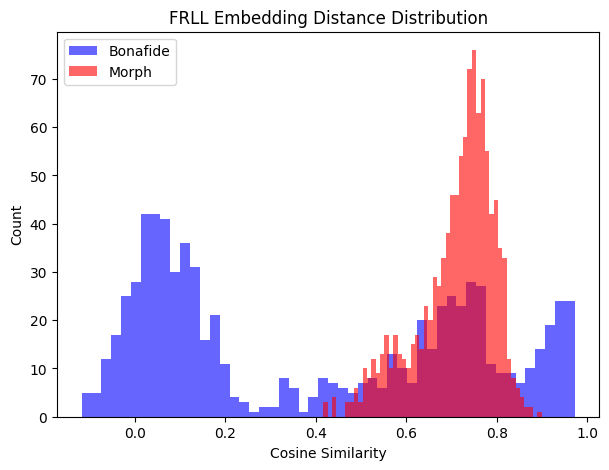

In [24]:
plot_embedding_distance_distribution(dmad_model, frll_test_loader,device)


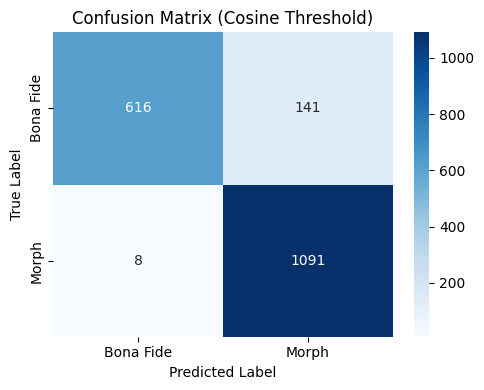

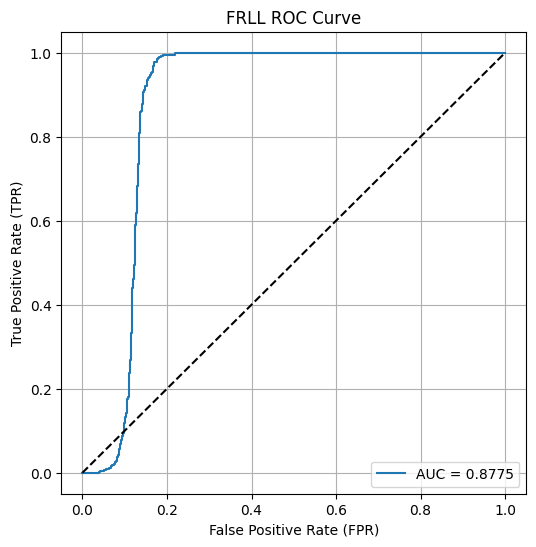

In [25]:
all_cos = results["_all_cos"]
all_labels = results["_all_labels"]
best_t     = results["cosine"]["threshold"]

plot_confusion_matrix(all_labels, all_cos, best_t)


plot_roc_curve(all_labels, all_cos, "FRLL ROC Curve")


In [26]:
import shutil

src = "/kaggle/working/dmad_checkpoint.pth"
dst = "/kaggle/working/dmad_checkpoint_0.2.pth"

shutil.copy(src, dst)

print("Checkpoint duplicated to working folder ✔")


Checkpoint duplicated to working folder ✔


In [27]:
print("Loading the checkpoint ")
checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

dmad_model.load_state_dict(checkpoint["model_state_dict"])   # 🔥 correct
# (Only load optimizer if you want to fine-tune again)

print("✔ Checkpoint model loaded successfully.")


Loading the checkpoint 
✔ Checkpoint model loaded successfully.


In [28]:
# ============================================
# FINE-TUNE THE D-MAD MODEL USING FRLL
# ============================================
print("\n============== FINE-TUNING ON FRLL ==============\n")

# =======================================================
# STAGE 1 — WARM-UP (Encoder frozen)
# =======================================================
print("🔒 Stage 1: Freezing encoder for warm-up...")

for p in dmad_model.encoder.parameters():
    p.requires_grad = False    # freeze encoder

optimizer_ft = optim.AdamW(
    filter(lambda p: p.requires_grad, dmad_model.parameters()),
    lr=5e-5,
    weight_decay=1e-5
)

FRLL_STAGE1 = "/kaggle/working/dmad_frll_stage3.pth"

dmad_model = train_dmad(
    model=dmad_model,
    train_loader=frll_finetune_loader,
    val_loader=dmad_val_loader,
    optimizer=optimizer_ft,
    num_epochs=3,
    freeze_epochs=0,         # ❗ NO freeze inside training (we freeze manually)
    reset_checkpoint=True
)

torch.save(dmad_model.state_dict(), FRLL_STAGE1)
print(f"✔ Stage 1 warm-up saved to {FRLL_STAGE1}")




============== FINE-TUNING ON FRLL ==============

🔒 Stage 1: Freezing encoder for warm-up...
Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 0 epochs.

Epoch 1/3
----------------------------------------
Encoder UNFROZEN at epoch 1 ✔
train Loss: 0.8650 Acc: 0.9237
val Loss: 4.3699 Acc: 0.2727
Checkpoint saved ✔

Epoch 2/3
----------------------------------------
train Loss: 0.7530 Acc: 0.9324
val Loss: 4.8513 Acc: 0.2535
Checkpoint saved ✔

Epoch 3/3
----------------------------------------
train Loss: 0.7456 Acc: 0.9335
val Loss: 5.7804 Acc: 0.2607
Checkpoint saved ✔

Training finished.
Best val Acc: 0.2727
✔ Stage 1 warm-up saved to /kaggle/working/dmad_frll_stage3.pth


In [29]:
print("Loading the FRLL First Stage model ")

dmad_model.load_state_dict(
    torch.load("dmad_frll_stage3.pth", map_location=device)
)

print("✔ FRLL Stage 1 model loaded successfully.")


Loading the FRLL First Stage model 
✔ FRLL Stage 1 model loaded successfully.


In [30]:
# =======================================================
# STAGE 2 — FULL FINE-TUNING (Encoder unfreeze)
# =======================================================
print("\n🔓 Stage 2: Unfreezing encoder for full fine-tuning...")

for p in dmad_model.encoder.parameters():
    p.requires_grad = True   # unfreeze encoder

optimizer_ft2 = optim.AdamW(
    dmad_model.parameters(),
    lr=1e-5,           # smaller LR for stability
    weight_decay=1e-5
)

FRLL_STAGE2 = "/kaggle/working/dmad_frll_stage4.pth"

dmad_model = train_dmad(
    model=dmad_model,
    train_loader=frll_finetune_loader,
    val_loader=dmad_val_loader,
    optimizer=optimizer_ft2,
    num_epochs=3,
    freeze_epochs=0,        # ❗ FULLY UNFROZEN — no auto-freeze
    reset_checkpoint=True
)

torch.save(dmad_model.state_dict(), FRLL_STAGE2)
print(f"\n🔥 Fine-tuning complete. Saved to {FRLL_STAGE2}")


🔓 Stage 2: Unfreezing encoder for full fine-tuning...
Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 0 epochs.

Epoch 1/3
----------------------------------------
Encoder UNFROZEN at epoch 1 ✔
train Loss: 0.7257 Acc: 0.9367
val Loss: 5.0911 Acc: 0.2424
Checkpoint saved ✔

Epoch 2/3
----------------------------------------
train Loss: 0.6041 Acc: 0.9421
val Loss: 5.2708 Acc: 0.2501
Checkpoint saved ✔

Epoch 3/3
----------------------------------------
train Loss: 0.4660 Acc: 0.9551
val Loss: 6.1190 Acc: 0.2631
Checkpoint saved ✔

Training finished.
Best val Acc: 0.2631

🔥 Fine-tuning complete. Saved to /kaggle/working/dmad_frll_stage4.pth


In [31]:
checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])

# Run test
evaluate_dmad_both(dmad_model, dmad_test_loader, dataset_name="FEI D-MAD")



==================== FEI D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       88.77%
Precision:      0.8430
Recall:         0.9941
F1-Score:       0.9123
ROC-AUC:        0.7387

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.9099
Accuracy:       81.59%
Precision:      0.7625
Recall:         0.9975
F1-Score:       0.8643
ROC-AUC:        0.6121
FAR:            0.0025
FRR:            0.4430
EER:            0.3938
Avg Bona Cosine:        0.8667
Avg Morph Cosine:       0.9536



{'classifier': {'accuracy': 0.8876793666501732,
  'precision': 0.8429693076374019,
  'recall': 0.9941077441077442,
  'f1': 0.9123213595983006,
  'roc_auc': 0.7387439824414613},
 'cosine': {'threshold': 0.9099099099099099,
  'accuracy': 0.8159327065809006,
  'precision': 0.7625482625482626,
  'recall': 0.9974747474747475,
  'f1': 0.8643326039387309,
  'roc_auc': 0.612083217125234,
  'FAR': 0.0025252525252525255,
  'FRR': 0.4429771908763505,
  'EER': 0.3937575030012005},
 '_all_cos': array([0.66939914, 0.9900085 , 0.9878499 , ..., 0.94004714, 0.94577754,
        0.9395882 ], dtype=float32),
 '_all_labels': array([0, 0, 0, ..., 1, 1, 1])}

In [32]:

checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

dmad_model.load_state_dict(checkpoint["model_state_dict"])


# Run test
results1= evaluate_dmad_both(dmad_model, frll_test_loader, dataset_name="FRLL D-MAD")


==================== FRLL D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       99.25%
Precision:      0.9874
Recall:         1.0000
F1-Score:       0.9937
ROC-AUC:        1.0000

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.8799
Accuracy:       82.49%
Precision:      0.7752
Recall:         0.9918
F1-Score:       0.8703
ROC-AUC:        0.7749
FAR:            0.0082
FRR:            0.4174
EER:            0.2708
Avg Bona Cosine:        0.8352
Avg Morph Cosine:       0.9397



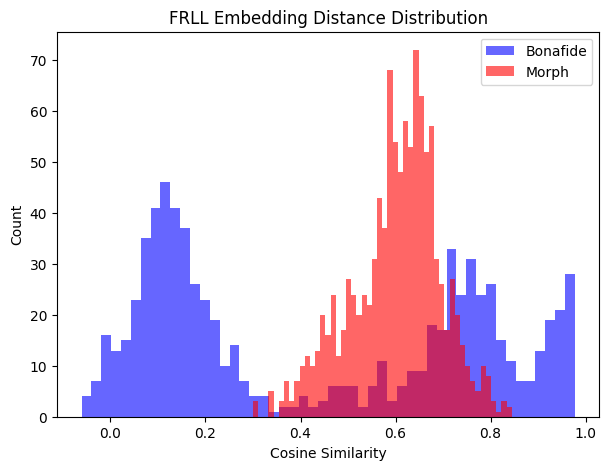

In [33]:
plot_embedding_distance_distribution(dmad_model, frll_test_loader,device)


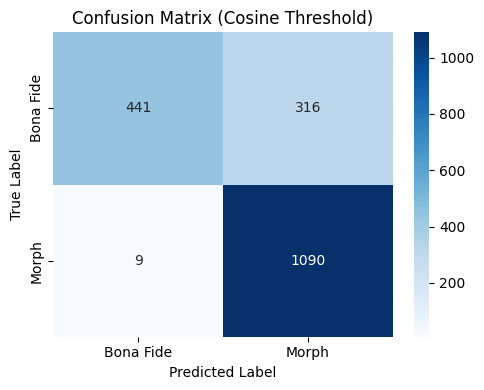

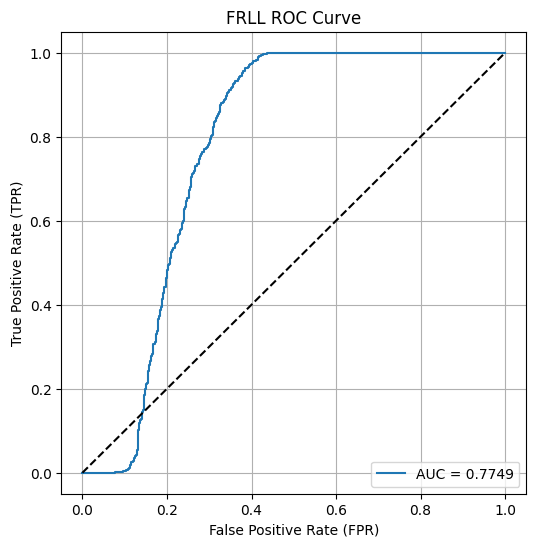

In [34]:
all_cos1 = results1["_all_cos"]
all_labels1 = results1["_all_labels"]
best_t1     = results1["cosine"]["threshold"]

plot_confusion_matrix(all_labels1, all_cos1, best_t1)


plot_roc_curve(all_labels1, all_cos1, "FRLL ROC Curve")


In [35]:
import shutil

src = "/kaggle/working/dmad_checkpoint.pth"
dst = "/kaggle/working/dmad_checkpoint_0.3.pth"

shutil.copy(src, dst)

print("Checkpoint duplicated to working folder ✔")


Checkpoint duplicated to working folder ✔


In [36]:
print("Loading the checkpoint ")
checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

dmad_model.load_state_dict(checkpoint["model_state_dict"])   # 🔥 correct
# (Only load optimizer if you want to fine-tune again)

print("✔ Checkpoint model loaded successfully.")


Loading the checkpoint 
✔ Checkpoint model loaded successfully.


In [37]:
# ============================================
# FINE-TUNE THE D-MAD MODEL USING FRLL
# ============================================
print("\n============== FINE-TUNING ON FRLL ==============\n")

# =======================================================
# STAGE 1 — WARM-UP (Encoder frozen)
# =======================================================
print("🔒 Stage 1: Freezing encoder for warm-up...")

for p in dmad_model.encoder.parameters():
    p.requires_grad = False    # freeze encoder

optimizer_ft = optim.AdamW(
    filter(lambda p: p.requires_grad, dmad_model.parameters()),
    lr=5e-5,
    weight_decay=1e-5
)

FRLL_STAGE1 = "/kaggle/working/dmad_frll_stage5.pth"

dmad_model = train_dmad(
    model=dmad_model,
    train_loader=frll_finetune_loader,
    val_loader=dmad_val_loader,
    optimizer=optimizer_ft,
    num_epochs=3,
    freeze_epochs=0,         # ❗ NO freeze inside training (we freeze manually)
    reset_checkpoint=True
)

torch.save(dmad_model.state_dict(), FRLL_STAGE1)
print(f"✔ Stage 1 warm-up saved to {FRLL_STAGE1}")




============== FINE-TUNING ON FRLL ==============

🔒 Stage 1: Freezing encoder for warm-up...
Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 0 epochs.

Epoch 1/3
----------------------------------------
Encoder UNFROZEN at epoch 1 ✔
train Loss: 0.4250 Acc: 0.9551
val Loss: 8.0047 Acc: 0.2708
Checkpoint saved ✔

Epoch 2/3
----------------------------------------
train Loss: 0.3785 Acc: 0.9605
val Loss: 8.0710 Acc: 0.2626
Checkpoint saved ✔

Epoch 3/3
----------------------------------------
train Loss: 0.3596 Acc: 0.9611
val Loss: 8.0412 Acc: 0.2530
Checkpoint saved ✔

Training finished.
Best val Acc: 0.2708
✔ Stage 1 warm-up saved to /kaggle/working/dmad_frll_stage5.pth


In [38]:
print("Loading the FRLL First Stage model ")

dmad_model.load_state_dict(
    torch.load("dmad_frll_stage5.pth", map_location=device)
)

print("✔ FRLL Stage 1 model loaded successfully.")


Loading the FRLL First Stage model 
✔ FRLL Stage 1 model loaded successfully.


In [39]:
# =======================================================
# STAGE 2 — FULL FINE-TUNING (Encoder unfreeze)
# =======================================================
print("\n🔓 Stage 2: Unfreezing encoder for full fine-tuning...")

for p in dmad_model.encoder.parameters():
    p.requires_grad = True   # unfreeze encoder

optimizer_ft2 = optim.AdamW(
    dmad_model.parameters(),
    lr=1e-5,           # smaller LR for stability
    weight_decay=1e-5
)

FRLL_STAGE2 = "/kaggle/working/dmad_frll_stage6.pth"

dmad_model = train_dmad(
    model=dmad_model,
    train_loader=frll_finetune_loader,
    val_loader=dmad_val_loader,
    optimizer=optimizer_ft2,
    num_epochs=3,
    freeze_epochs=0,        # ❗ FULLY UNFROZEN — no auto-freeze
    reset_checkpoint=True
)

torch.save(dmad_model.state_dict(), FRLL_STAGE2)
print(f"\n🔥 Fine-tuning complete. Saved to {FRLL_STAGE2}")


🔓 Stage 2: Unfreezing encoder for full fine-tuning...
Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 0 epochs.

Epoch 1/3
----------------------------------------
Encoder UNFROZEN at epoch 1 ✔
train Loss: 0.3632 Acc: 0.9578
val Loss: 9.5429 Acc: 0.2771
Checkpoint saved ✔

Epoch 2/3
----------------------------------------
train Loss: 0.2910 Acc: 0.9665
val Loss: 9.0552 Acc: 0.2684
Checkpoint saved ✔

Epoch 3/3
----------------------------------------
train Loss: 0.3142 Acc: 0.9670
val Loss: 10.3647 Acc: 0.2833
Checkpoint saved ✔

Training finished.
Best val Acc: 0.2833

🔥 Fine-tuning complete. Saved to /kaggle/working/dmad_frll_stage6.pth


In [40]:
checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])

# Run test
evaluate_dmad_both(dmad_model, dmad_test_loader, dataset_name="FEI D-MAD")



==================== FEI D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       50.07%
Precision:      0.7077
Recall:         0.2567
F1-Score:       0.3768
ROC-AUC:        0.7499

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.9479
Accuracy:       84.07%
Precision:      0.7871
Recall:         0.9992
F1-Score:       0.8806
ROC-AUC:        0.6857
FAR:            0.0008
FRR:            0.3854
EER:            0.3277
Avg Bona Cosine:        0.8838
Avg Morph Cosine:       0.9756



{'classifier': {'accuracy': 0.5007422068283028,
  'precision': 0.7076566125290024,
  'recall': 0.25673400673400676,
  'f1': 0.3767757875231625,
  'roc_auc': 0.7498949074579327},
 'cosine': {'threshold': 0.9479479479479479,
  'accuracy': 0.8406729341909945,
  'precision': 0.7871352785145889,
  'recall': 0.9991582491582491,
  'f1': 0.8805637982195845,
  'roc_auc': 0.685652038593215,
  'FAR': 0.0008417508417508417,
  'FRR': 0.38535414165666265,
  'EER': 0.3277310924369748},
 '_all_cos': array([0.8298625 , 0.9896713 , 0.98097634, ..., 0.97478294, 0.970958  ,
        0.9689108 ], dtype=float32),
 '_all_labels': array([0, 0, 0, ..., 1, 1, 1])}

In [41]:

checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

dmad_model.load_state_dict(checkpoint["model_state_dict"])


# Run test
results2= evaluate_dmad_both(dmad_model, frll_test_loader, dataset_name="FRLL D-MAD")


==================== FRLL D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       99.95%
Precision:      0.9991
Recall:         1.0000
F1-Score:       0.9995
ROC-AUC:        1.0000

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.7958
Accuracy:       63.90%
Precision:      0.6312
Recall:         0.9390
F1-Score:       0.7549
ROC-AUC:        0.4733
FAR:            0.0610
FRR:            0.7966
EER:            0.4967
Avg Bona Cosine:        0.8701
Avg Morph Cosine:       0.8659



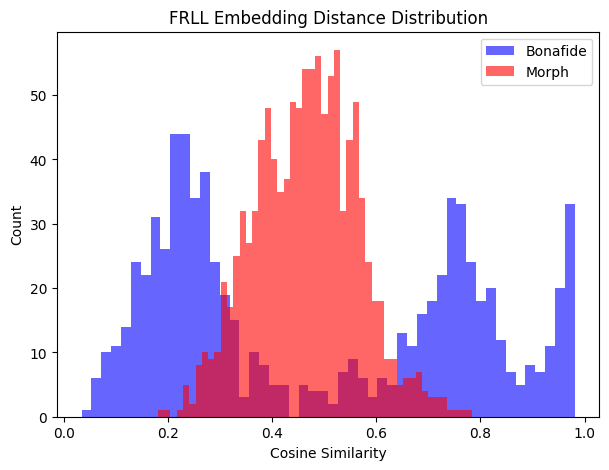

In [42]:
plot_embedding_distance_distribution(dmad_model, frll_test_loader,device)


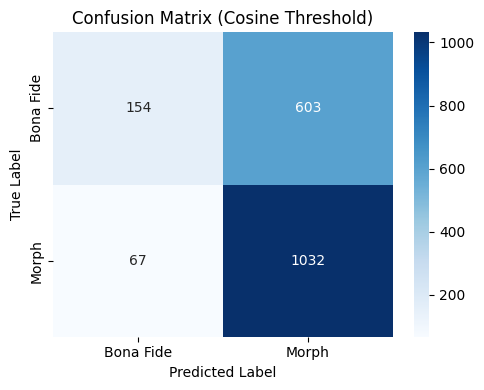

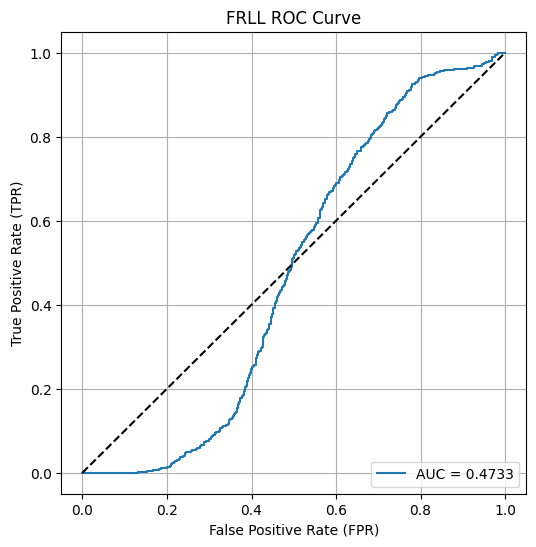

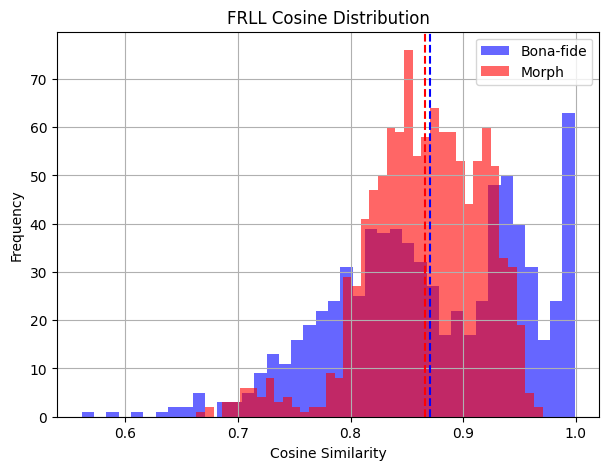

In [43]:
all_cos2 = results2["_all_cos"]
all_labels2 = results2["_all_labels"]
best_t2     = results2["cosine"]["threshold"]

plot_confusion_matrix(all_labels2, all_cos2, best_t2)


plot_roc_curve(all_labels2, all_cos2, "FRLL ROC Curve")
plot_cosine_distribution(all_cos2, all_labels2, "FRLL Cosine Distribution")
